In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, GRU, SimpleRNN
from keras import initializers
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from keras.utils import plot_model
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import pickle
import scipy.io as sio
import numpy as np
from numpy import linalg as la
import argparse
from keras.utils import to_categorical
from sklearn.model_selection import KFold, StratifiedKFold

## Perfmetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, matthews_corrcoef, balanced_accuracy_score, precision_recall_fscore_support
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, roc_curve,roc_auc_score
import tensorflow
import re
import pandas as pd
!pip install wget
import wget

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
feature_extraction = wget.download('https://raw.githubusercontent.com/Shujaat123/ACP-LSTM-NFR/main/feature_extraction.py')
acp740_path = 'https://raw.githubusercontent.com/Shujaat123/ACP-LSTM-NFR/main/data/acp740.txt'
name_740 = acp740_path.split('https://raw.githubusercontent.com/Shujaat123/ACP-LSTM-NFR/main/data/')[1]
acp740 = tensorflow.keras.utils.get_file(name_740, acp740_path)

from feature_extraction import *

In [3]:
def ACP_DL(path, gap1=4,gap2=4, folds = 5):
    # define parameters
    timesteps = 1
    batch_size = 64
    epochs = 30

    # get data
    [DataX, LabelY] = Convert_Seq2CKSSCP(prepare_feature_acp740_2(path), gap1=gap1,gap2=gap2)
    bpf, kmer, label = prepare_feature_acp740(path)
    X = np.concatenate((bpf, kmer), axis=1) # k-mer with binary
    X = np.concatenate((X, DataX), axis=1)  # add side chain
    data_dim = len(X[0])
    #  expected input data shape: (batch_size, timesteps, data_dim)
    X = np.reshape(X, (len(X), timesteps, data_dim))

    stats = []

    num_cross_val = folds  # 5-fold
    all_labels = []
    all_prob = {}
    all_prob[0] = []

    for fold in range(num_cross_val):
        train = np.array([x for i, x in enumerate(X) if i % num_cross_val != fold])
        test = np.array([x for i, x in enumerate(X) if i % num_cross_val == fold])
        train_label = np.array([x for i, x in enumerate(label) if i % num_cross_val != fold])
        test_label = np.array([x for i, x in enumerate(label) if i % num_cross_val == fold])
        real_labels = []
        for val in test_label:
            if val == 1:
                real_labels.append(1)
            else:
                real_labels.append(0)

        train_label_new = []
        for val in train_label:
            if val == 1:
                train_label_new.append(1)
            else:
                train_label_new.append(0)
        all_labels = all_labels + real_labels

        model = Sequential()
        model.add(LSTM(128, return_sequences=False,input_shape=(timesteps, data_dim), name='lstm1'))  # returns a sequence of vectors of dimension 32
        model.add(Dropout(0.25, name='dropout'))
        model.add(Dense(1, name='full_connect'))
        model.add(Activation('sigmoid'))
        model.summary()

        print('Compiling the Model...')
        model.compile(loss='binary_crossentropy',  #
              optimizer='adam',
              metrics=['accuracy'])

        print("Train...")

        model.fit(train, train_label, batch_size=batch_size,epochs=epochs, verbose=0)

        lstm_proba = model.predict(test)
        all_prob[0] = all_prob[0] + [val for val in lstm_proba]
        y_pred_xgb = transfer_label_from_prob(lstm_proba)

        t_acc, t_sen, t_spe, t_f1, t_mcc, t_bacc, t_yi = Calculate_Stats(test_label,y_pred_xgb)
        stats.append([t_sen, t_spe, t_acc, t_bacc, t_mcc, t_yi, t_f1])

        print(t_sen, t_spe, t_acc, t_bacc, t_mcc, t_yi, t_f1)
        print('---' * 30)

    mean_stat={}
    mean_stat['Sn']=np.mean(stats,axis=0)[0]
    mean_stat['Sp']=np.mean(stats,axis=0)[1]
    mean_stat['Acc']=np.mean(stats,axis=0)[2]
    mean_stat['Bal.Acc.']=np.mean(stats,axis=0)[3]
    mean_stat['MCC']=np.mean(stats,axis=0)[4]
    mean_stat['YI']=np.mean(stats,axis=0)[5]
    mean_stat['F1-score']=np.mean(stats,axis=0)[6]
    print('Mean stats:')
    print(mean_stat)

    std_stat={}
    std_stat['Sn']=np.std(stats,axis=0)[0]
    std_stat['Sp']=np.std(stats,axis=0)[1]
    std_stat['Acc']=np.std(stats,axis=0)[2]
    std_stat['Bal.Acc.']=np.std(stats,axis=0)[3]
    std_stat['MCC']=np.std(stats,axis=0)[4]
    std_stat['YI']=np.std(stats,axis=0)[5]
    std_stat['F1-score']=np.std(stats,axis=0)[6]
    print('\nStd stats:')
    print(std_stat)
    print('---' * 30)

    '''
    print('Mean stats:')
    print(np.mean(stats,axis=0))
    print('Std stats:')
    print(np.std(stats,axis=0))
    '''
    plot_roc_curve(all_labels, all_prob[0], 'proposed method')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    #plt.savefig( f'{i}' +' plot.jpg')
    plt.show()
    plt.close()

num pos: 364 num neg: 376


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 128)                 │         389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ full_connect (Dense)                 │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389,249 (1.48 MB)

 Trainable params: 389,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model...
Train...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0.8289473684210527 0.8333333333333334 0.831081081081081 0.8311403508771931 0.6620992301242483 0.6622807017543861 0.8344370860927153
------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 128)                 │         389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ full_connect (Dense)                 │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389,249 (1.48 MB)

 Trainable params: 389,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model...
Train...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0.88 0.8904109589041096 0.8851351351351351 0.8852054794520547 0.770340611375414 0.7704109589041095 0.8859060402684564
------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 128)                 │         389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ full_connect (Dense)                 │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389,249 (1.48 MB)

 Trainable params: 389,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model...
Train...


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0.92 0.8493150684931506 0.8851351351351351 0.8846575342465753 0.7717859193051604 0.7693150684931507 0.8903225806451613
------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 128)                 │         389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ full_connect (Dense)                 │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389,249 (1.48 MB)

 Trainable params: 389,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model...
Train...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
0.88 0.863013698630137 0.8716216216216216 0.8715068493150685 0.7432173477222522 0.743013698630137 0.8741721854304636
------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm1 (LSTM)                         │ (None, 128)                 │         389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ full_connect (Dense)                 │ (None, 1)                   │             129 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 389,249 (1.48 MB)

 Trainable params: 389,249 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Compiling the Model...
Train...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0.96 0.821917808219178 0.8918918918918919 0.890958904109589 0.7906302532682788 0.781917808219178 0.9
------------------------------------------------------------------------------------------
Mean stats:
{'Sn': 0.8937894736842104, 'Sp': 0.8515981735159818, 'Acc': 0.8729729729729729, 'Bal.Acc.': 0.8726938236000962, 'MCC': 0.7476146723590709, 'YI': 0.7453876472001923, 'F1-score': 0.8769675784873593}

Std stats:
{'Sn': 0.04394456341505296, 'Sp': 0.0239018307366254, 'Acc': 0.02195686055307017, 'Bal.Acc.': 0.02173193536662187, 'MCC': 0.04535038039231612, 'YI': 0.04346387073324374, 'F1-score': 0.022827183917673244}
------------------------------------------------------------------------------------------


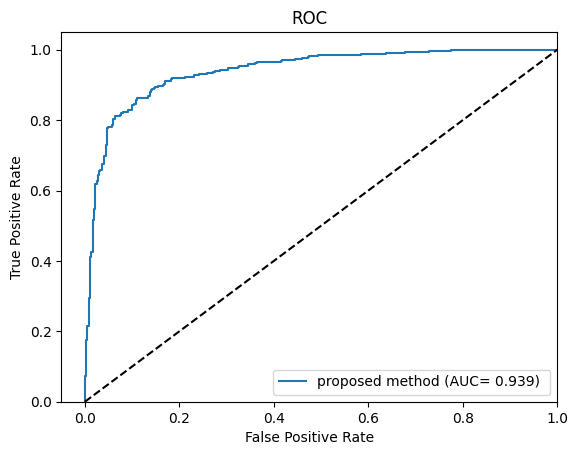

In [4]:
ACP_DL(acp740, gap1=1,gap2=5, folds = 5)